### File Load & Preprocessing

In [21]:
from google.colab import files, drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
import re
import pandas as pd
import numpy as np

import os
os.chdir("/content/gdrive/My Drive/KorBERT")

In [23]:
import pandas as pd
df = pd.read_csv("new_token.csv")

In [24]:
df.head()

,Unnamed: 0,media,a_num,title,content,w_num,c_source,a_source,s_num,v_num,nf_verb,s_verb,reporter,non_text,s_rate,quality,depend,depend_type,len
0,0,경기일보,329412764,"105만 고양시 발전 이끌어온 서기관 6명, 아름다운 퇴장","송주현 기자 왼쪽 위부터)김운용, 이현옥, 이흥민, 노양호, 정종현, 신승일 특례시...",1176,6,1,18,16,0,8,1,0,50.0,1,위해 공직자(서기관)들이 앞두고 있다. 되기까지 이들은 물려주고 중이다. 푸른도시사...,위하/VV 어/EC 공직/NNG 자/XSN (/SS 서기/NNG 관/XSN )/SS...,225
1,1,경기일보,329412768,고양시 새해에는 교통난 해결될까 관심,송주현 기자 고양시민들이 출퇴근길 겪고 있는 교통 불편이 새해에는 개선될 수 있을지...,1197,3,1,14,16,0,6,1,0,37.5,1,고양시민들이 겪고 불편이 수 있을지 관심이 모아진다. 따르면 구간)은 운행하고 있어...,고양/NNP 시민/NNG 들/XSN 이/JKS 겪/VV 고/EC 불편/NNG 이/J...,188
2,2,경기일보,329412771,"안양시, 오는 2022년까지 일자리 10만6천개 창출 목표",박준상 기자 기해년을 맞은 안양시가 향후 4년간 일자리 10만6천여개 창출을 목표로...,884,2,0,9,10,0,0,1,0,0.0,1,"안양시가 공시했다. 따르면 종합계획은 하며, 담고 있다. 핵심전략은 청년이 강화이다...",안양시/NNP 가/JKS 공시/NNG 하/XSV 었/EP 다/EF ./SF 따르/V...,95
3,3,경기일보,329412773,"오명근 의원, 평택 고평지구 학군조정을 위한 의견수렴 간담회 개최",최현호 기자 경기도의회 건설교통위원회 소속 오명근 의원(더불어민주당평택4)은 지난 ...,759,9,3,9,10,0,2,1,0,20.0,1,의원(더불어민주당평택4)은 참석해 대해 논의했다. 일원)는 입주예정이다. 평택교육청...,의원/NNG (/SS 더불어민주당평택/NNP 4/SN )/SS 은/JX 참석/NNG...,134
4,4,경기일보,329412774,"화성시, 2020년까지 신규 일자리 13만개 창출...일자리 대책 청사진 공개",홍완식 기자 화성시가 새해를 맞아 민선7기 지역맞춤형 일자리 대책의 청사진을 공개했...,937,2,0,8,8,0,0,1,0,0.0,1,화성시가 맞아 공개했다. 시는 통해 공시했다. 시는 꼽았다. 등이다. 시는 구상이다...,화성시/NNP 가/JKS 맞/VV 아/EC 공개/NNG 하/XSV 었/EP 다/EF...,78


### 실행X

In [6]:
def cleaned_text(text):
  text = text.replace('\\r',' ')
  text = text.replace('\\n','')
  _filter = re.compile('[^가-힣 0-9 a-z A-Z \@ \( \) \. \, \' \" \! \?]+')
  text = _filter.sub('', text)
  for i in range(2,20):
    text = text.replace(' '*i,' ')
  return text
df['content'] = df['content'].apply(lambda x : cleaned_text(x))

In [7]:
df_merge = pd.concat([a,df],axis=1)

NameError: ignored

In [ ]:
df_merge.shape

In [ ]:
df_merge

### ETRI에서 제공하는 형태소분석기 API 사용 (실행 X)

In [8]:
import collections       # OrderedDict를 위해 호출
#import unicodedata       # 한국어 정준분해 및 문자열 확인
import six               # Python version 체크
import tensorflow as tf  # Tensorflow 파일 불러오기 및 logging
import urllib3
import json
from tqdm import tqdm

In [9]:
#ETRI에서 제공해주는 형태소분석API를 사요하기 위한 Key(각자 키 사용할 것)

from tokenization_morp import load_vocab
api_key ='f750a1f6-3ae0-40d5-89c5-c2243cb70093'
#api_key = 'f3639d57-7635-4bd9-93b0-6eae550ab90e'
#vocab 로드
vocab_file = 'vocab.korean_morp.list'
morph_vocab = load_vocab(vocab_file)
depend_list = ['SBJ']

In [10]:
def do_lang1 ( openapi_key, text ) :
    
    openApiURL = "http://aiopen.etri.re.kr:8000/WiseNLU"
	 
    requestJson = { "access_key": openapi_key, "argument": { "text": text, "analysis_code": "dparse" } }
	 
    http = urllib3.PoolManager()
    response = http.request( "POST", openApiURL, headers={"Content-Type": "application/json; charset=UTF-8"}, body=json.dumps(requestJson))
    
    json_data = json.loads(response.data.decode('utf-8'))
    json_result = json_data["result"]
    
    if json_result == -1:
        json_reason = json_data["reason"]
        if "Invalid Access Key" in json_reason:
            logger.info(json_reason)
            logger.info("Please check the openapi access key.")
            sys.exit()
        return "openapi error - " + json_reason      
    else:
        json_data = json.loads(response.data.decode('utf-8'))
    
        json_return_obj = json_data["return_object"]
        
        return_result = ""
        ls_return = []
        json_sentence = json_return_obj["sentence"]
        for json_morp in json_sentence:                        
            for morp in json_morp["dependency"]:
              if (morp["label"] == 'VP') | (morp["label"] == 'VNP')  : 
                return_result = return_result+str(morp["text"])+" "
              for depend in depend_list:
                if depend in morp["label"]:
                  return_result = return_result+str(morp["text"])+" "
              
  
        return return_result

In [11]:
df.content[1]

'송주현 기자 고양시민들이 출퇴근길 겪고 있는 교통 불편이 새해에는 개선될 수 있을지 관심이 모아진다. 31일 고양시 등에 따르면 현재 경의선(서울문산 구간)은 불과 4량을 운행하고 있어 출퇴근 시간대 배차간격이 최대 30분 이상 소요되는 등 시민들에게 지옥철로 불리고 있다. 파주와 고양을 관통하는 대표 고속화도로인 자유로도 하루 평균 22만 대 이상의 차량이 오가며 전국 최다 교통량을 보이고 있고 파주고양서울을 연결하는 최단 노선인 통일로 역시 교통상황이 포화상태를 겪으며 교통난은 계속되고 있다. 시는 이같은 문제를 해결하기 위해 최근 김현미 국토부 장관과의 정책 건의자리에서 시민의 원활한 출퇴근길을 위한 광역교통 여건 개선에 정부가 적극 협력해 달라고 요청했다. 시의 요청사항은 우선 출퇴근 시간대 경의선 간격을 단축하고, 열차 칸을 4량에서 6량으로 증차다. 열차 한 량이 버스 3대 이상의 운행 효과를 얻을 것으로 판단해서다. 또 포화 상태인 육상 교통의 대안으로 고양 킨텍스에서 서울 강남까지 관통하는 광역 지하도로 구축을 건의했다. 광역지하도로는 킨텍스강남 간 통행시간이 83분에서 22분대로 4분의 1 가량 줄어드는 획기적인 대안 교통망으로 주목된다. 광역지하도로는 수도권 서북부의 교통난 해소에 기여할 뿐 아니라 남북과 유라시아를 잇는 아시안 하이웨이 역할도 수행할 수 있다. 이는 한반도 평화무드를 맞아 정부가 구상하는 한반도 신경제지도의 토대가 되는 중요한 사업인 만큼 정부의 적극적인 검토를 요청했다. 3호선 파주 연장과 관련해서도 예비타당성 조사를 면제하고 조속히 추진해 줄 것과 파주고양서울을 연결하는 최단 노선인 통일로의 교통 포화상태를 해결할 대안으로 3호선을 고양시 지축역에서 파주시 조리금촌까지 연장하는 안을 건의했다. 이재준 고양시장은 광역교통 확충은 곧 도시의 균형발전으로 이어진다. 분단 이후 접경지역이라는 한계에 부딪혀 65년 간 산업 발전에서 소외되고 낙후돼 온 경기 서북부 도시들이 동반 성장하는 계기가 될 것이라며 정부 차원의 적극적인 

In [12]:
df.depend[1]

'고양시민들이 겪고 불편이 수 있을지 관심이 모아진다. 따르면 구간)은 운행하고 있어 배차간격이 불리고 있다. 차량이 오가며 보이고 있고 교통상황이 겪으며 교통난은 계속되고 있다. 시는 위해 정부가 협력해 요청했다. 요청사항은 단축하고, 증차다. 량이 판단해서다. 건의했다. 통행시간이 가량 주목된다. 아니라 수 있다. 이는 맞아 정부가 요청했다. 관련해서도 면제하고 추진해 건의했다. 고양시장은 확충은 이어진다. 부딪혀 소외되고 낙후돼 도시들이 것이라며 요청했다. 국토부장관은 남북철도 착공 강조하며 국토부도 위해 말했다. '

In [13]:
df.depend_type[1]

'고양/NNP 시민/NNG 들/XSN 이/JKS 겪/VV 고/EC 불편/NNG 이/JKS 수/NNG 있/VA 을지/EC 관심/NNG 이/JKS 모으/VV 아/EC 지/VX ㄴ다/EF ./SF 따르/VV 면/EC 구간/NNG )/SS 은/JX 운행/NNG 하/XSV 고/EC 있/VX 어/EC 배차/NNG 간격/NNG 이/JKS 불리/VV 고/EC 있/VX 다/EF ./SF 차량/NNG 이/JKS 오가/VV 며/EC 보이/VV 고/EC 있/VX 고/EC 교통/NNG 상황/NNG 이/JKS 겪/VV 으며/EC 교통/NNG 난/XSN 은/JX 계속/NNG 되/XSV 고/EC 있/VX 다/EF ./SF 시/NNG 는/JX 위하/VV 어/EC 정부/NNG 가/JKS 협력/NNG 하/XSV 어/EC 요청/NNG 하/XSV 었/EP 다/EF ./SF 요청/NNG 사항/NNG 은/JX 단축/NNG 하/XSV 고/EC ,/SP 증차/NNG 이/VCP 다/EF ./SF 량/NNG 이/JKS 판단해서/VV 다/EF ./SF 건의/NNG 하/XSV 었/EP 다/EF ./SF 통행/NNG 시간/NNG 이/JKS 가량/XSN 주목/NNG 되/XSV ㄴ다/EF ./SF 아니/VCN 라/EC 수/NNB 있/VA 다/EF ./SF 이/NP 는/JX 맞/VV 아/EC 정부/NNG 가/JKS 요청/NNG 하/XSV 었/EP 다/EF ./SF 관련/NNG 하/XSV 어서/EC 도/JX 면제/NNG 하/XSV 고/EC 추진/NNG 하/XSV 어/EC 건의/NNG 하/XSV 었/EP 다/EF ./SF 고양/NNP 시장/NNG 은/JX 확충/NNG 은/JX 이어지/VV ㄴ다/EF ./SF 부딪히/VV 어/EC 소외/NNG 되/XSV 고/EC 낙후/NNG 되/XSV 어/EC 도시/NNG 들/XSN 이/JKS 것/NNB 이/VCP 라며/EC 요청/NNG 하/XSV 었/EP 다/EF ./SF 국토부/NNG 장관/NNG 은/JX 남북철/NNP 도/JX 착공/NNG 강조/NNG 하/XSV 며/EC 국토부/NNG

In [16]:
df['depend'] = df['content'].apply(lambda x : do_lang1(api_key, x))

In [17]:
def do_lang ( openapi_key, text ) :
    openApiURL = "http://aiopen.etri.re.kr:8000/WiseNLU"
	 
    requestJson = { "access_key": openapi_key, "argument": { "text": text, "analysis_code": "morp" } }
	 
    http = urllib3.PoolManager()
    response = http.request( "POST", openApiURL, headers={"Content-Type": "application/json; charset=UTF-8"}, body=json.dumps(requestJson))
    
    json_data = json.loads(response.data.decode('utf-8'))
    json_result = json_data["result"]
    
    if json_result == -1:
        json_reason = json_data["reason"]
        if "Invalid Access Key" in json_reason:
            logger.info(json_reason)
            logger.info("Please check the openapi access key.")
            sys.exit()
        return "openapi error - " + json_reason      
    else:
        json_data = json.loads(response.data.decode('utf-8'))
    
        json_return_obj = json_data["return_object"]
        
        return_result = ""
        json_sentence = json_return_obj["sentence"]
        for json_morp in json_sentence:                        
            for morp in json_morp["morp"]:
                return_result = return_result+str(morp["lemma"])+"/"+str(morp["type"])+" "

        return return_result

In [18]:
df['depend_type'] = df['depend'].apply(lambda x : do_lang(api_key, x))

In [ ]:
df.to_csv("new_token.csv")

In [ ]:
df.drop(813,axis=0,inplace=True)

In [ ]:
df.shape

(1002, 18)

### KorBert

In [ ]:
from tokenization_morp import load_vocab
#vocab 로드
vocab_file = 'vocab.korean_morp.list'

from tokenization_morp import FullTokenizer
ftk = FullTokenizer(vocab_file,False)

### Data 셋 구축

In [ ]:
import numpy as np
from tqdm import tqdm

morph_vocab = load_vocab(vocab_file)

def toktok_n_v(df):
    maxlen = 512
    ipt_ids = []
    ipt_mask = []   
    sgm_ids = []


    for content in tqdm(df['depend_type']):
        
        split_tokens = ftk.tokenize(content)
        tokens = ["[CLS]"] + split_tokens + ["[SEP]"]

        input_ids = [morph_vocab[token] for token in tokens]

        input_mask = [1] * len(input_ids)

        segment_ids = [0] * len(tokens)

        padding = [0] * (maxlen - len(input_ids))

        input_ids += padding

        input_mask += padding

        segment_ids += padding

        ipt_ids.append(input_ids) # 토큰

        ipt_mask.append(input_mask)


        sgm_ids.append(segment_ids) # 문장 분류

    
    ar_tok = np.array(ipt_ids)

    ar_seg = np.array(sgm_ids)

    train_x = [[ar_tok[:900]], [ar_seg[:900]]]
    test_x = [[ar_tok[900:]], [ar_seg[900:]]]

    y = df['quality']
    train_y = np.array(y[:900])
    test_y = np.array(y[900:])
    
    return train_x, test_x, train_y, test_y

In [ ]:
train_x, test_x, train_y, test_y = toktok_n_v(df)

100%|██████████| 1002/1002 [00:01<00:00, 611.87it/s]


### Keras 및 KorBERT를 활용한 뉴스 품질 예측

In [ ]:
import tensorflow as tf

import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

In [ ]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
!pip install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=312af32d78afabdcc19557b5fd49129d6a49a9e36ddbfd0dd00576c36ada2fe8
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp36-none-any.whl size=12942 sha256=59491cbafa5c1781526dc339466c114b869ae237b18e0a0c2e646e0eb2cb31d1
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=37fbc5e17d94a1db6c031438ef1f64cc278d7c2617cbbedbd25fa4882b559334
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15612 sha256=266448611f7b18bad0beb834030802f4dccf6a70155e64d97798e7a8462c7c86
  Stor

In [ ]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

In [ ]:
SEQ_LEN = 512


pretrained_path ="/content/gdrive/My Drive/korbert"
config_path = os.path.join(pretrained_path, 'ckpt/bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'ckpt/model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.korean_morp.list')

In [ ]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 512, 768), ( 23308032    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 512, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

In [ ]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'Encoder-12-MultiHeadSelfAttention':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    
    else:
        layer.trainable = False

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,Input-Token,False
1,<tensorflow.python.keras.engine.input_layer.In...,Input-Segment,False
2,<keras_bert.layers.embedding.TokenEmbedding ob...,Embedding-Token,False
3,<tensorflow.python.keras.layers.embeddings.Emb...,Embedding-Segment,False
4,<tensorflow.python.keras.layers.merge.Add obje...,Embedding-Token-Segment,False
...,...,...,...
107,<keras_bert.layers.embedding.EmbeddingSimilari...,MLM-Sim,True
108,<tensorflow.python.keras.engine.input_layer.In...,Input-Masked,True
109,<tensorflow.python.keras.layers.core.Dense obj...,NSP-Dense,True
110,<keras_bert.layers.masked.Masked object at 0x7...,MLM,True


In [ ]:
from tensorflow import optimizers
import tensorflow_addons as tfa

In [ ]:
LR=3e-5

In [ ]:
def get_bert_finetuning_model(model):
    inputs = model.inputs[:2]
    dense = model.layers[-3].output
    #drop = keras.layers.Dropout(0.2)(dense)
    outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)
    bert_model = keras.models.Model(inputs, outputs)
    bert_model.compile(
      #optimizer=tfa.optimizers.RectifiedAdam(learning_rate=LR,weight_decay  = 0.0025),
      optimizer=tf.optimizers.Adam(learning_rate=LR),
      loss='binary_crossentropy',
      metrics=['accuracy'])
    
    return bert_model

In [ ]:
checkpoint = tf.train.Checkpoint(model=get_bert_finetuning_model(model))

In [ ]:
checkpoint.restore(checkpoint_path).run_restore_ops()

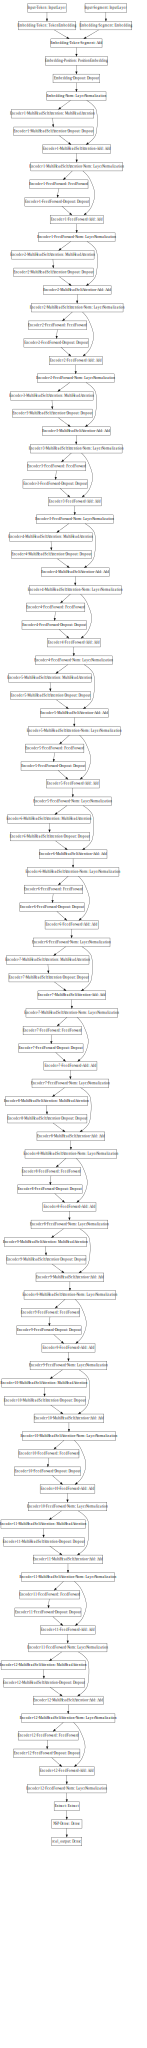

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [ ]:
bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=5, batch_size=16, verbose = 1, validation_split=0.1, shuffle=True)

Epoch 1/5
51/51 [==============================] - 64s 1s/step - loss: 0.2576 - accuracy: 0.9716 - val_loss: 0.8367 - val_accuracy: 0.5889
Epoch 2/5
51/51 [==============================] - 61s 1s/step - loss: 0.1221 - accuracy: 0.9778 - val_loss: 0.9417 - val_accuracy: 0.6000
Epoch 3/5
51/51 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9864

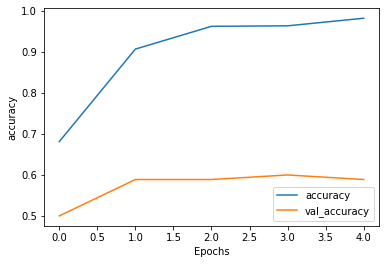

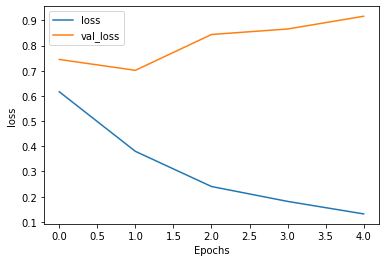

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# history를 그래프로 그리기 위해 사용
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


  # 그래프 그리기
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
preds = bert_model.predict(test_x)

from sklearn.metrics import classification_report

# F1 Score 확인
print(classification_report(test_y, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.61      0.89      0.72        47
           1       0.85      0.51      0.64        55

    accuracy                           0.69       102
   macro avg       0.73      0.70      0.68       102
weighted avg       0.74      0.69      0.68       102



In [ ]:
bert_model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
!mkdir -p saved_model
bert_model.save('saved_model/my_model') 